In [162]:
from collections import Counter, defaultdict
import re
import nltk
import json
from nltk.tokenize import word_tokenize
from sklearn.metrics import precision_recall_fscore_support

def get_stats(vocab):
    """Get counts of pairs of consecutive symbols."""
    pairs = Counter()
    for word, freq in vocab.items():
        symbols = word.split()  # Ensure words are split into characters as initial symbols
        for i in range(len(symbols) - 1):
            pairs[symbols[i], symbols[i + 1]] += freq
    return pairs

def merge_vocab(pair, v_in):
    """Merge a pair of symbols to produce a new vocabulary."""
    v_out = {}
    bigram = ' '.join(pair)  # Join the pair with spaces
    p = re.compile(r'(?<!\S)' + re.escape(bigram) + r'(?!\S)')  # Use the escaped bigram
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word]
    return v_out

def learn_bpe_vocab(corpus, num_merges):
    """Learn a BPE vocabulary from a given corpus."""
    # Ensure the corpus is a list of words
    if isinstance(corpus, str):
        corpus = corpus.split()

    # Initial vocabulary: words are split into characters as symbols
    vocab = Counter()
    for word in corpus:
        # Add space between characters to treat them as separate symbols
        vocab[' '.join(word) + ' </w>'] += 1  # Adding </w> to mark end of word
    original_vocab = dict(vocab)

    merge_frequencies = []
    vocab_evolution = []

    for i in range(num_merges):
        pairs = get_stats(vocab)
        if not pairs:
            break
        best = max(pairs, key=pairs.get)
        vocab = merge_vocab(best, vocab)
        merge_frequencies.append(pairs[best])  # Append the frequency of the best pair
        vocab_evolution.append(dict(vocab))

    return vocab, original_vocab, merge_frequencies, vocab_evolution



def encode_text(text, bpe_vocab):
    """Encode a text using the learned BPE vocabulary."""
    words = text.split()
    encoded_words = []
    for word in words:
        while len(word) > 1:
            # Find the best pair to merge in the current word
            pairs = [(a, b) for a, b in zip(word, word[1:])]
            best_pair = min(pairs, key=lambda pair: bpe_vocab.get(pair, float('inf')))

            if best_pair not in bpe_vocab:
                break

            # Merge the best pair in the word
            best_pair_str = ''.join(best_pair)
            word = best_pair_str.join(word.split(' '.join(best_pair)))

        encoded_words.append(word)

    return ' '.join(encoded_words)

def decode_text(encoded_text, bpe_vocab):
    """Decode a text using the learned BPE vocabulary."""
    # To decode, we simply replace the merged symbols with their original pairs
    for pair in bpe_vocab:
        merged_symbol = ''.join(pair)
        encoded_text = encoded_text.replace(merged_symbol, ' '.join(pair))
    return encoded_text


In [ ]:
# Downloading the necessary NLTK components and the Gutenberg Corpus texts
nltk.download('gutenberg')
nltk.download('punkt')

from nltk.corpus import gutenberg

emma_text = gutenberg.raw('austen-emma.txt')
blake_poems_text = gutenberg.raw('blake-poems.txt')
hamlet_text = gutenberg.raw('shakespeare-hamlet.txt')

# Concatenating the texts to form a single corpus
combined_corpus = emma_text + blake_poems_text + hamlet_text

train_texts, original_vocab, merge_frequencies,vocab_evolution = learn_bpe_vocab(combined_corpus, 100) # BPE tarined on combined_corpus of all 3 books

sample_text = "this is a test for encoding and decoding"
encoded_text = encode_text(sample_text, train_texts)
decoded_text = decode_text(encoded_text, train_texts)
merge_frequencies, encoded_text, decoded_text

In [132]:
edgeworth_text = gutenberg.raw('edgeworth-parents.txt')
whitman_text = gutenberg.raw('whitman-leaves.txt')
shakespeare_text = gutenberg.raw('shakespeare-macbeth.txt')
test_texts = [edgeworth_text, whitman_text, shakespeare_text]  # Load these texts

In [ ]:
# This function conisders 'bpe_tokens' is a list of lists containing the tokens of each text as tokenized by the BPE algorithm
# and 'nltk_token' is a list of lists containing the tokens of each text as tokenized by NLTK's word_tokenize.

def evaluate_tokenization(nltk_tokens, bpe_tokens):
    # Flatten the lists for evaluation
    flat_nltk_tokens = [token for sublist in nltk_tokens for token in sublist]
    flat_bpe_tokens = [token for sublist in bpe_tokens for token in sublist]

    # We assume that every token in the BPE tokenization that matches a token in the NLTK tokenization is a 'true positive'
    # Every token in the BPE tokenization that does not match is a 'false positive'
    # Every token in the NLTK tokenization that is not found in the BPE tokenization is a 'false negative'
    true_positives = set(flat_bpe_tokens).intersection(set(flat_nltk_tokens))
    false_positives = set(flat_bpe_tokens).difference(set(flat_nltk_tokens))
    false_negatives = set(flat_nltk_tokens).difference(set(flat_bpe_tokens))

    # Calculate precision, recall, and F1-score
    precision = len(true_positives) / (len(true_positives) + len(false_positives))
    recall = len(true_positives) / (len(true_positives) + len(false_negatives))
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Calculate accuracy (this is a simple match and doesn't take into account the order of tokens)
    correct_tokens = sum(token in flat_nltk_tokens for token in flat_bpe_tokens)
    accuracy = correct_tokens / len(flat_bpe_tokens) * 100

    # Calculate coverage
    coverage = len(true_positives) / len(set(flat_nltk_tokens)) * 100

    # Prepare the results in a dictionary
    results = {
        'Accuracy': accuracy,
        'Coverage': coverage,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score
    }

    return results

# Evaluate the tokenization
evaluation_results_edgeowth = evaluate_tokenization(edgeworth_text, train_texts)
evaluation_results_whitman = evaluate_tokenization(whitman_text, train_texts)
evaluation_results_shakespeare = evaluate_tokenization(shakespeare_text, train_texts)

evaluation_results_edgeowth, evaluation_results_whitman, evaluation_results_shakespeare



In [ ]:
import nltk
from nltk.tokenize import word_tokenize
import json
# Download the Punkt tokenizer models
nltk.download('punkt')

# test_texts is a list of strings, each string being the raw text of a book
nltk_tokenized_texts = [word_tokenize(text) for text in test_texts]


# Example: Saving the tokenized results to a JSON file
nltk_tokenized_texts = {
    "edgeworth_parents": nltk_tokenized_texts[0],
    "whitman_leaves": nltk_tokenized_texts[1],
    "shakespeare_macbeth": nltk_tokenized_texts[2]
}

with open('tokenized_texts1.json', 'w', encoding='utf-8') as f:
    json.dump(nltk_tokenized_texts, f, ensure_ascii=False, indent=4)


In [ ]:
# using encode_text is defined as per the previous BPE code
# And bpe_vocab is your learned BPE vocabulary

bpe_tokenized_texts = [encode_text(text, train_texts) for text in test_texts]

token_evaluation = evaluate_tokenization(nltk_tokenized_texts, bpe_tokenized_texts)
token_evaluation

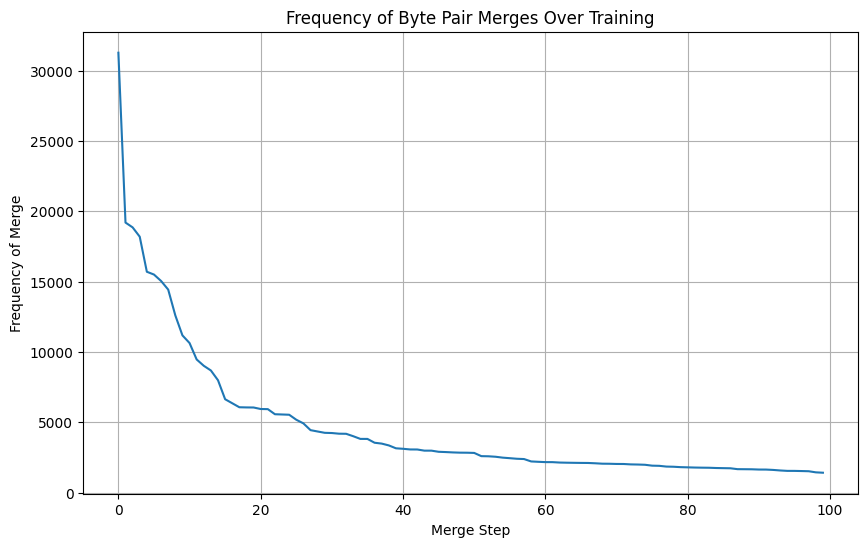

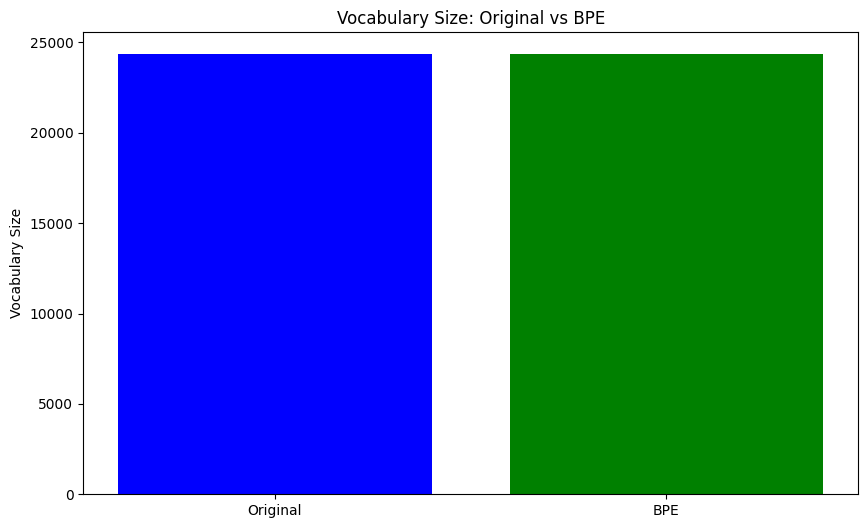

In [165]:
import matplotlib.pyplot as plt

# Visualizing merge frequencies
plt.figure(figsize=(10, 6))
plt.plot(merge_frequencies)
plt.title("Frequency of Byte Pair Merges Over Training")
plt.xlabel("Merge Step")
plt.ylabel("Frequency of Merge")
plt.grid(True)  # Adding grid for better readability


# Comparing the vocabulary size before and after training
vocab_sizes = [len(original_vocab), len(train_texts)]
vocab_labels = ['Original', 'BPE']

plt.figure(figsize=(10, 6))
plt.bar(vocab_labels, vocab_sizes, color=['blue', 'green'])
plt.title("Vocabulary Size: Original vs BPE")
plt.ylabel("Vocabulary Size")
plt.show()
